<a href="https://colab.research.google.com/github/priyanshgupta1998/All_codes/blob/master/Predict_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

In [3]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d dgawlik/nyse

 76% 25.0M/32.8M [00:00<00:00, 50.2MB/s]
100% 32.8M/32.8M [00:00<00:00, 109MB/s] 


In [6]:
!unzip nyse.zip

Archive:  nyse.zip
  inflating: fundamentals.csv        
  inflating: prices-split-adjusted.csv  
  inflating: prices.csv              
  inflating: securities.csv          


In [7]:
prices_dataset =  pd.read_csv('prices.csv', header=0)
print(prices_dataset.shape)
prices_dataset.head()

(851264, 7)


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [8]:
prices_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [12]:
print(prices_dataset['symbol'].nunique() , prices_dataset['symbol'].unique())
prices_dataset['symbol'].value_counts().head()

501 ['WLTW' 'A' 'AAL' 'AAP' 'AAPL' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADS' 'ADSK' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIZ' 'AJG' 'AKAM'
 'ALB' 'ALK' 'ALL' 'ALXN' 'AMAT' 'AME' 'AMG' 'AMGN' 'AMP' 'AMT' 'AMZN'
 'AN' 'ANTM' 'AON' 'APA' 'APC' 'APD' 'APH' 'ARNC' 'ATVI' 'AVB' 'AVGO'
 'AVY' 'AWK' 'AXP' 'AYI' 'AZO' 'BA' 'BAC' 'BAX' 'BBBY' 'BBT' 'BBY' 'BCR'
 'BDX' 'BEN' 'BHI' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BSX' 'BWA' 'BXP' 'C'
 'CA' 'CAG' 'CAH' 'CAT' 'CB' 'CBG' 'CBS' 'CCI' 'CCL' 'CELG' 'CERN' 'CF'
 'CHD' 'CHK' 'CHRW' 'CI' 'CINF' 'CL' 'CLX' 'CMA' 'CMCSA' 'CME' 'CMG' 'CMI'
 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COH' 'COL' 'COO' 'COP' 'COST' 'CPB' 'CRM'
 'CSCO' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS' 'CVX' 'CXO' 'D' 'DAL' 'DD'
 'DE' 'DFS' 'DG' 'DGX' 'DHI' 'DHR' 'DIS' 'DISCA' 'DISCK' 'DLR' 'DLTR'
 'DNB' 'DOV' 'DOW' 'DPS' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN' 'EA' 'EBAY' 'ECL'
 'ED' 'EFX' 'EIX' 'EL' 'EMN' 'EMR' 'ENDP' 'EOG' 'EQIX' 'EQR' 'EQT' 'ES'
 'ESRX' 'ESS' 'ETFC' 'ETN' 'ETR' 'EW' 'EXC' 'EXPD' '

C       1762
UHS     1762
NBL     1762
WYN     1762
AMZN    1762
Name: symbol, dtype: int64

In [13]:
yahoo = prices_dataset[prices_dataset['symbol']=='YHOO']
print(yahoo.shape)
yahoo.head()

(1762, 7)


,date,symbol,open,close,low,high,volume
713,2010-01-04,YHOO,16.940001,17.100000,16.879999,17.200001,16587400.0
1181,2010-01-05,YHOO,17.219999,17.230000,17.000000,17.230000,11718100.0
1649,2010-01-06,YHOO,17.170000,17.170000,17.070000,17.299999,16422000.0
2117,2010-01-07,YHOO,16.809999,16.700001,16.570000,16.900000,31816300.0
2585,2010-01-08,YHOO,16.680000,16.700001,16.620001,16.760000,15470000.0


In [17]:
yahoo_stock_prices = yahoo.close.values.astype('float32')
yahoo_stock_prices.shape  #1762 columns

(1762,)

In [18]:
yahoo_stock_prices = yahoo_stock_prices.reshape(1762, 1)
yahoo_stock_prices.shape

(1762, 1)

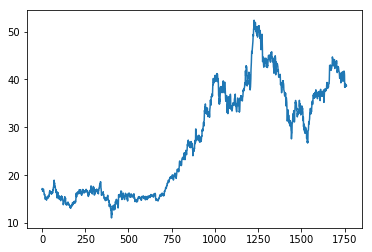

In [19]:
plt.plot(yahoo_stock_prices)
plt.show()

In [0]:
#Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) 
yahoo_stock_prices = scaler.fit_transform(yahoo_stock_prices)

In [21]:
train_size = int(len(yahoo_stock_prices) * 0.80)
test_size = len(yahoo_stock_prices) - train_size
train = yahoo_stock_prices[0:train_size,:]
test = yahoo_stock_prices[train_size:len(yahoo_stock_prices),:]
print(len(train), len(test))

1409 353


In [31]:
print(train.shape ,train[:5])
print('\n')
print(test.shape ,test[:5])

(1409, 1) [[0.14559111]
 [0.14874032]
 [0.14728683]
 [0.13590118]
 [0.13590118]]


(353, 1) [[0.6312985 ]
 [0.6041666 ]
 [0.5668605 ]
 [0.60174423]
 [0.60925394]]


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [32]:
print(trainX.shape ,trainX[:5])
print('\n')
print(testX.shape ,testX[:5])

(1407, 1) [[0.14559111]
 [0.14874032]
 [0.14728683]
 [0.13590118]
 [0.13590118]]


(351, 1) [[0.6312985 ]
 [0.6041666 ]
 [0.5668605 ]
 [0.60174423]
 [0.60925394]]


In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1 , trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1 , testX.shape[1]))

In [34]:
print(trainX.shape ,trainX[:5])
print('\n')
print(testX.shape ,testX[:5])

(1407, 1, 1) [[[0.14559111]]

 [[0.14874032]]

 [[0.14728683]]

 [[0.13590118]]

 [[0.13590118]]]


(351, 1, 1) [[[0.6312985 ]]

 [[0.6041666 ]]

 [[0.5668605 ]]

 [[0.60174423]]

 [[0.60925394]]]


In [35]:
%time

#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))

model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  if __name__ == '__main__':


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compilation time :  0.02353048324584961


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    validation_split=0.05)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1336 samples, validate on 71 samples
Epoch 1/10
1336/1336 [==============================] - 2s 2ms/step - loss: 0.1321 - val_loss: 0.2926
Epoch 2/10
1336/1336 [==============================] - 0s 96us/step - loss: 0.0701 - val_loss: 0.1449
Epoch 3/10
1336/1336 [==============================] - 0s 84us/step - loss: 0.0418 - val_loss: 0.0734
Epoch 4/10
1336/1336 [==============================] - 0s 88us/step - loss: 0.0313 - val_loss: 0.0439
Epoch 5/10
1336/1336 [==============================] - 0s 86us/step - loss: 0.0203 - val_loss: 0.0183
Epoch 6/10
1336/1336 [==============================] - 0s 84us/step - loss: 0.0103 - val_loss: 0.0086
Epoch 7/10
1336/1336 [==============================] - 0s 87us/step - loss: 0.0039 - val_loss: 0.0017
Epoch 8/10
1336/1336 [==============================] - 0s 81us/step - loss: 0.0021 - val_loss: 7.8612e-04
Epoch 9/10
1336/1336 [==============================] - 0s 81us/step - loss: 0.0019 - val_loss: 9.5939e-04
Epoch 10/10
1336/133

In [0]:
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

In [63]:
predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)

[[0.6025403]]
[[1.4345411]]
[[3.3465278]]
[[7.786174]]
[[14.1151705]]


In [64]:
print(len(predictions))
predictions

5


[0.6025403, 1.4345411, 3.3465278, 7.786174, 14.1151705]

In [65]:
np.array(predictions)

array([ 0.6025403,  1.4345411,  3.3465278,  7.786174 , 14.1151705],
      dtype=float32)

#### USE "scaler.inverse_transform()"   Scale back the data to the original representation.

In [61]:
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))

[[ 0.60254025]
 [ 1.434541  ]
 [ 3.3465273 ]
 [ 7.786173  ]
 [14.115169  ]]


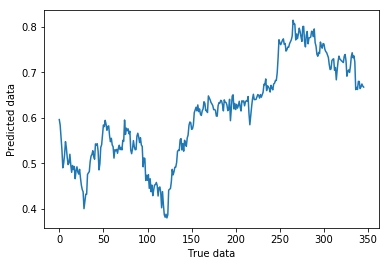

In [66]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])  #X label
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])  #Y label
    plt.xlabel('True data')
    plt.ylabel('Predicted data')
    plt.show()
    
plot_results_multiple(predictions, testY, predict_length)